# CS 6140 Machine Learning: Final Group Project
## Philip Butler, Riley Grant, Benjamin Ruzzo

words words words

In [1]:
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sbn
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score


# df = pd.read_csv("./data/CountyState_Alc_Cig_HDDeath.csv")
df = pd.read_csv("./data/data_all_features.csv")
df.head()

,county_state,hyp_total_2009,cig_total_2012,cig_daily_2012,obs_total_2006,dbt_total_2012,alc_any_2008,alc_heavy_2008,alc_binge_2008,hd_deaths_per100k_over65
0,"Autauga, AL",38.87,25.10,18.41,67.26,11.44,41.2,6.0,13.1,1292.6
1,"Baldwin, AL",36.79,20.90,16.02,76.59,9.76,55.1,9.1,17.7,1182.2
2,"Barbour, AL",47.63,26.25,18.73,59.95,14.65,37.0,5.6,12.0,1508.6
3,"Bibb, AL",43.28,29.41,22.62,59.95,12.32,34.2,5.2,11.6,1362.3
4,"Blount, AL",40.80,27.17,19.88,62.09,11.14,34.1,4.8,10.8,1327.2


## Clean and Join Disparate Data Sets

In [2]:
import json

In [3]:
# clean alcohol dataset
def clean_alcohol(year, saveHuh):
    
    # import the cigarette data
    alc_df = pd.read_csv('data/clean_alcohol_allyears.csv')

    col_to_keep_any = str(year) + " any"
    col_to_keep_heavy = str(year) + " heavy"
    col_to_keep_binge = str(year) + " binge"

    # get list of columns to keep
    list_column_names = list(alc_df)
    list_column_names.remove(col_to_keep_any)
    list_column_names.remove(col_to_keep_heavy)
    list_column_names.remove(col_to_keep_binge)
    list_column_names.remove('county_state')

    # # drop irrelevant rows
    # hyp_df = hyp_df.dropna(subset=['County']) # drop all 'NaN' counties

    # drop everything that's not the given year, or county and state
    alc_df.drop(list_column_names, axis=1, inplace=True)

    # # drop unneeded columns
    # # reorder the whole thing
    # hyp_df = hyp_df[['county_state', 'hyp_total_' + str(year_to_keep),'State', 'state_abbrev','County']]
    alc_df.rename(
        columns = 
        {
            col_to_keep_any: 'alc_any_' + str(year), 
            col_to_keep_heavy: 'alc_heavy_' + str(year),
            col_to_keep_binge: 'alc_binge_' + str(year)
        }, inplace=True)
    # hyp_df.drop(['state', 'state_abbrev', 'county'], axis=1, inplace=True)

    # drop the old index column that exists in the csv for some reason

    # reset index
    alc_df.reset_index(drop=True, inplace=True)

    if saveHuh:
        alc_df.to_csv('data/clean_alcohol.csv', index = False)

    return alc_df

In [4]:
# clean cigarette dataset
def clean_cigarette(year, saveHuh):


    # import the cigarette data
    cig_df = pd.read_csv('data/original_cigarette.csv')

    # putting this bad larry as a variable so we can change which year
    #   if we do correlation stuff later on in the process
    year_to_keep = year


    # === clean data 

    # clean the cigarette dataframe

    # drop irrelevant rows
    cig_df = cig_df.dropna(subset=['county']) # drop all 'NaN' counties
    cig_df = cig_df[cig_df.sex == 'Both'] # keep only 'both' sexes row
    cig_df = cig_df[cig_df.year == year_to_keep] # keep only one year

    # rename counties for consistenty, drop any suffixes (__ County, __ Borough, __ City, ..., etc)
    cig_df['county_short'] = cig_df['county']
    cig_df.loc[cig_df['county'].str.endswith(" County"), 'county_short'] = cig_df['county'].str.removesuffix(" County") # drop county, works for most
    cig_df.loc[cig_df['county'].str.endswith(" Parish"), 'county_short'] = cig_df['county'].str.removesuffix(" Parish") # drop 'Parish', for Louisiana
    cig_df.loc[cig_df['county'].str.endswith(" City"), 'county_short'] = cig_df['county'].str.removesuffix(" City") # drop 'City', for a few states. More consistent to drop it all the time.

    # alaska shiz - so inconsistent
    cig_df.loc[cig_df['county'].str.endswith(" Borough"), 'county_short'] = cig_df['county'].str.removesuffix(" Borough") 
    cig_df.loc[cig_df['county'].str.endswith(" Census Area"), 'county_short'] = cig_df['county'].str.removesuffix(" Census Area") 
    cig_df.loc[cig_df['county'].str.endswith(" Municipality"), 'county_short'] = cig_df['county'].str.removesuffix(" Municipality") 




    # === rename states to country code, add a column
    # import json
    sta_json = open('data/states_to_abbrev.json')
    states_to_abbrev_dict = json.load(sta_json)

    cig_df['state_abbrev'] = cig_df['state']
    cig_df['state_abbrev'] = cig_df.loc[:, 'state']


    cig_df = cig_df.replace( {
        'state_abbrev': states_to_abbrev_dict
    })



    # # create single column for joining
    # cig_df['state_county'] = cig_df['county']
    cig_df['county_state'] = cig_df.loc[:, 'county_short'] + ', ' + cig_df.loc[:, 'state_abbrev']



    # rename column headers - make sure they're readable as cigarette data
    cig_df.rename(columns = {
        'state'      : 'state_full',
        'county'     : 'county_full',
        'sex'        : 'cig_sex',
        'year'       : 'cig_year',
        'total_mean' : 'cig_total',
        'total_lb'   : 'cig_total_lb',
        'total_ub'   : 'cig_total_ub',
        'daily_mean' : 'cig_daily',
        'daily_lb'   : 'cig_daily_lb',
        'daily_ub'   : 'cig_daily_ub',
    }, inplace = True)


    # re-order the whole bad larry
    cig_df = cig_df[ 
        [
            'county_state', 'county_short', 'state_abbrev',
            'cig_total', 'cig_daily',
            'county_full', 'state_full',
            'cig_sex', 'cig_year',
            'cig_total_lb', 'cig_total_ub', 'cig_daily_lb', 'cig_daily_ub',
        ] 
    ]

    # drop the old index column
    # cig_df.drop(cig_df.columns[0], axis=1, inplace=True) # drop the old index
    cig_df.reset_index(drop=True, inplace=True)

    # OPTIONAL - remove all unneeded columns? just keep the total_mean, daily_mean
    cig_df.drop(['cig_sex', 'cig_year'], axis=1, inplace=True) # drop sex and year, irrelevant now
    cig_df.drop(['cig_total_lb', 'cig_total_ub', 'cig_daily_lb', 'cig_daily_ub'], axis=1, inplace=True) # drop upper and lower bounds, only keep mean
    cig_df.drop(['county_short', 'state_abbrev', 'county_full', 'state_full'], axis=1, inplace=True)

    cig_df.rename(columns={
        'cig_total': 'cig_total_' + str(year),
        'cig_daily': 'cig_daily_' + str(year)
    }, inplace=True)

    # optional - save it as a csv
    if saveHuh:
        cig_df.to_csv('data/clean_cigarette.csv', index = False)
    
    return cig_df

In [5]:
# clean the diabetes dataset
def clean_diabetes(year, saveHuh):
    
    # import the cigarette data
    dbt_df = pd.read_csv('data/modified_diabetes.csv')

    # drop irrelevant rows
    dbt_df = dbt_df.dropna(subset=['County']) # drop all 'NaN' counties

    col_to_keep = "Prevalence, " + str(year) + ", Both Sexes"

    # get list of columns to keep
    list_column_names = list(dbt_df)
    list_column_names.remove(col_to_keep)
    list_column_names.remove('State')
    list_column_names.remove('County')

    # drop everything that's not the given year, or county and state
    dbt_df.drop(list_column_names, axis=1, inplace=True)

    # fix up counties
    dbt_df.loc[dbt_df['County'].str.endswith(" County"), 'county_short'] = dbt_df['County'].str.removesuffix(" County") # drop county, works for most
    dbt_df.loc[dbt_df['County'].str.endswith(" Parish"), 'county_short'] = dbt_df['County'].str.removesuffix(" Parish") # drop county, works for most
    dbt_df.loc[dbt_df['County'].str.endswith(" City"), 'county_short'] = dbt_df['County'].str.removesuffix(" City") # drop county, works for most

    # alaska shiz
    dbt_df.loc[dbt_df['County'].str.endswith(" Borough"), 'county_short'] = dbt_df['County'].str.removesuffix(" Borough") # drop county, works for most
    dbt_df.loc[dbt_df['County'].str.endswith(" Census Area"), 'county_short'] = dbt_df['County'].str.removesuffix(" Census Area") # drop county, works for most
    dbt_df.loc[dbt_df['County'].str.endswith(" Municipality"), 'county_short'] = dbt_df['County'].str.removesuffix(" Municipality") # drop county, works for most



    # get state codes
    sta_json = open('data/states_to_abbrev.json')
    states_to_abbrev_dict = json.load(sta_json)
    dbt_df['state_abbrev'] = dbt_df['State']
    dbt_df['state_abbrev'] = dbt_df.loc[:, 'State']
    dbt_df = dbt_df.replace( {
        'state_abbrev': states_to_abbrev_dict
    })


    # create column to join on
    dbt_df['county_state'] = dbt_df.loc[:, 'county_short'] + ', ' + dbt_df.loc[:, 'state_abbrev']

    # drop unneeded columns
    # reorder the whole thing
    dbt_df.rename(columns = {'State': 'state', 'County': 'county', "Prevalence, " + str(year) + ", Both Sexes": "dbt_total_" + str(year)}, inplace=True)
    dbt_df = dbt_df[['county_state', 'dbt_total_' + str(year),'state', 'state_abbrev','county']]
    dbt_df.drop(['state', 'state_abbrev', 'county'], axis=1, inplace=True)

    # reset index
    dbt_df.reset_index(drop=True, inplace=True)

    if saveHuh:
        dbt_df.to_csv('data/clean_diabetes.csv', index = False)

    return dbt_df
    

In [6]:
# clean the heart disease dataset
def clean_heartdisease(saveHuh):
    
    # import the cigarette data
    hdd_df = pd.read_csv('data/CountyState_Alc_Cig_HDDeath.csv')

    # get list of columns to keep
    list_column_names = list(hdd_df)
    list_column_names.remove('deaths-per-100k')
    list_column_names.remove('county_state')


    # drop everything that's not the given year, or county and state
    hdd_df.drop(list_column_names, axis=1, inplace=True)

    hdd_df.rename(columns = {'deaths-per-100k': 'hd_deaths_per100k_over65'}, inplace=True)
    # hyp_df.drop(['state', 'state_abbrev', 'county'], axis=1, inplace=True)

    # reset index
    hdd_df.reset_index(drop=True, inplace=True)

    if saveHuh:
        hdd_df.to_csv('data/clean_heart_disease.csv', index = False)

    return hdd_df
    

In [7]:
# clean the hypertension dataset
def clean_hypertension(year, saveHuh):
    
    # import the cigarette data
    hyp_df = pd.read_csv('data/original_hypertension.csv')

    # putting this bad larry as a variable so we can change which year
    #   if we do correlation stuff later on in the process
    # year_to_keep = 2009
    year_to_keep = year

    col_to_keep_male = "Total, Male, " + str(year_to_keep)
    col_to_keep_female = "Total, Female, " + str(year_to_keep)
    # print(col_to_keep_female)

    # get list of columns to keep
    list_column_names = list(hyp_df)
    list_column_names.remove(col_to_keep_male)
    list_column_names.remove(col_to_keep_female)
    list_column_names.remove('State')
    list_column_names.remove('County')


    # drop irrelevant rows
    hyp_df = hyp_df.dropna(subset=['County']) # drop all 'NaN' counties

    # drop everything that's not the given year, or county and state
    hyp_df.drop(list_column_names, axis=1, inplace=True)

    # average the male and female, drop them after making combined one
    hyp_df['hyp_total_' + str(year_to_keep)] = ( pd.to_numeric(hyp_df[col_to_keep_male].str[:-1]) + pd.to_numeric(hyp_df[col_to_keep_male].str[:-1]) ) / 2
    hyp_df.drop([col_to_keep_male, col_to_keep_female], axis=1, inplace=True)



    # fix up counties
    hyp_df.loc[hyp_df['County'].str.endswith(" County"), 'county_short'] = hyp_df['County'].str.removesuffix(" County") # drop county, works for most
    hyp_df.loc[hyp_df['County'].str.endswith(" Parish"), 'county_short'] = hyp_df['County'].str.removesuffix(" Parish") # drop county, works for most
    hyp_df.loc[hyp_df['County'].str.endswith(" City"), 'county_short'] = hyp_df['County'].str.removesuffix(" City") # drop county, works for most

    # alaska shiz
    hyp_df.loc[hyp_df['County'].str.endswith(" Borough"), 'county_short'] = hyp_df['County'].str.removesuffix(" Borough") # drop county, works for most
    hyp_df.loc[hyp_df['County'].str.endswith(" Census Area"), 'county_short'] = hyp_df['County'].str.removesuffix(" Census Area") # drop county, works for most
    hyp_df.loc[hyp_df['County'].str.endswith(" Municipality"), 'county_short'] = hyp_df['County'].str.removesuffix(" Municipality") # drop county, works for most



    # get state codes
    sta_json = open('data/states_to_abbrev.json')
    states_to_abbrev_dict = json.load(sta_json)
    hyp_df['state_abbrev'] = hyp_df['State']
    hyp_df['state_abbrev'] = hyp_df.loc[:, 'State']
    hyp_df = hyp_df.replace( {
        'state_abbrev': states_to_abbrev_dict
    })


    # create column to join on
    hyp_df['county_state'] = hyp_df.loc[:, 'county_short'] + ', ' + hyp_df.loc[:, 'state_abbrev']

    # drop unneeded columns
    # reorder the whole thing
    hyp_df = hyp_df[['county_state', 'hyp_total_' + str(year_to_keep),'State', 'state_abbrev','County']]
    hyp_df.rename(columns = {'State': 'state', 'County': 'county'}, inplace=True)
    hyp_df.drop(['state', 'state_abbrev', 'county'], axis=1, inplace=True)

    # reset index
    hyp_df.reset_index(drop=True, inplace=True)

    if saveHuh:
        hyp_df.to_csv('data/clean_hypertension.csv', index = False)

    return hyp_df
    

In [8]:
# clean the obesity dataset
def clean_obesity(year, saveHuh):
    
    # import the cigarette data
    obs_df = pd.read_csv('data/original_obesity.csv')

    # putting this bad larry as a variable so we can change which year

    col_to_keep = 'Prevalence ' + str(year) + ' (%)'
    # print(col_to_keep_female)

    # get list of columns to keep
    list_column_names = list(obs_df)
    list_column_names.remove(col_to_keep)
    list_column_names.remove('State')
    list_column_names.remove('County')


    # drop irrelevant rows
    obs_df = obs_df.dropna(subset=['County']) # drop all 'NaN' counties
    obs_df = obs_df[obs_df.Sex != 'Male'] # kinda janky, tbh

    # drop everything that's not the given year, or county and state
    obs_df.drop(list_column_names, axis=1, inplace=True)

    # yah
    obs_df.rename(
        columns = 
        {
            'Prevalence ' + str(year) + ' (%)': 'obs_total_' + str(year),
            'State': 'state', 
            'County': 'county_state'
        }, inplace=True)

    obs_df.drop(['state'], axis=1, inplace=True)

    # reset index
    obs_df.reset_index(drop=True, inplace=True)
    # print(obs_df.head())

    if saveHuh:
        obs_df.to_csv('data/clean_obesity.csv', index = False)

    return obs_df
    

In [9]:
hyp_df = clean_hypertension(2009, True) # 2001, 2009    : 2009 is strongest
cig_df = clean_cigarette(2012, True)    # 1996 - 2012   : 2012 is strongest
obs_df = clean_obesity(2011, True)      # 2001 - 2011   : 2006 is least negative correlation (as time increases, more people are obese, and die of other complications?)
dbt_df = clean_diabetes(2012, True)     # 1999 - 2012   : 2012 is strongest (prolly similar, more time == more diabetes)
alc_df = clean_alcohol(2012, True)      # 2005 - 2012   : 2008 is least negative correlation
hdd_df = clean_heartdisease(True)  


# == change this line to check each correlation manually, looking for the best one
# merge_df = hyp_df.join( hdd_df.set_index('county_state'), on='county_state')
# merge_df = cig_df.join( hdd_df.set_index('county_state'), on='county_state')
# merge_df = obs_df.join( hdd_df.set_index('county_state'), on='county_state')
# merge_df = dbt_df.join( hdd_df.set_index('county_state'), on='county_state')
merge_df = alc_df.join( hdd_df.set_index('county_state'), on='county_state')

merge_df.dropna(inplace=True)

# check correlation here
print(merge_df.corr())

                          alc_any_2012  alc_heavy_2012  alc_binge_2012  \
alc_any_2012                  1.000000        0.794296        0.851249   
alc_heavy_2012                0.794296        1.000000        0.882982   
alc_binge_2012                0.851249        0.882982        1.000000   
hd_deaths_per100k_over65     -0.503848       -0.381379       -0.364785   

                          hd_deaths_per100k_over65  
alc_any_2012                             -0.503848  
alc_heavy_2012                           -0.381379  
alc_binge_2012                           -0.364785  
hd_deaths_per100k_over65                  1.000000  


In [10]:
# join all the data for individual year, using the best correlations found from the above cell
hyp_df = clean_hypertension(2009, True)
cig_df = clean_cigarette(2012, True)
obs_df = clean_obesity(2006, True)
dbt_df = clean_diabetes(2012, True)
alc_df = clean_alcohol(2008, True)
hdd_df = clean_heartdisease(True)


# merge all the datasets and printout the correlation matrix
merge_df = hyp_df.join( cig_df.set_index('county_state'), on='county_state')
merge_df = merge_df.join( obs_df.set_index('county_state'), on='county_state')
merge_df = merge_df.join( dbt_df.set_index('county_state'), on='county_state')
merge_df = merge_df.join( alc_df.set_index('county_state'), on='county_state')
merge_df = merge_df.join( hdd_df.set_index('county_state'), on='county_state')

merge_df.dropna(inplace=True)

merge_df.to_csv('data/data_all_features.csv', index = False)

## Observe Trends in Data

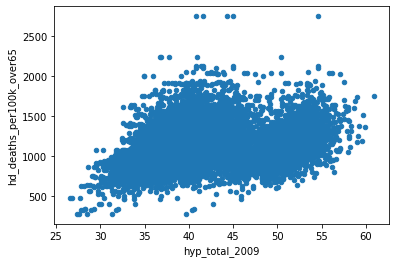

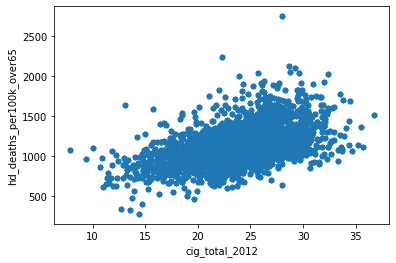

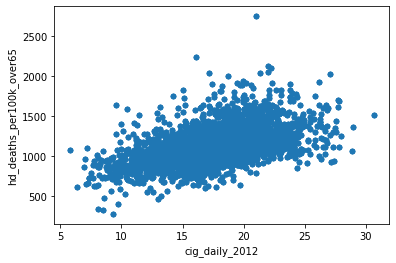

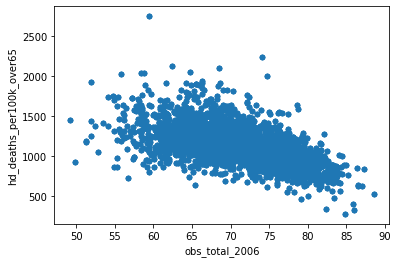

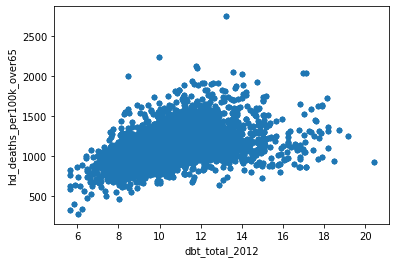

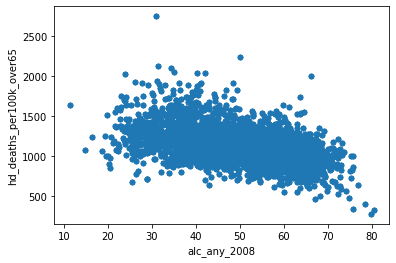

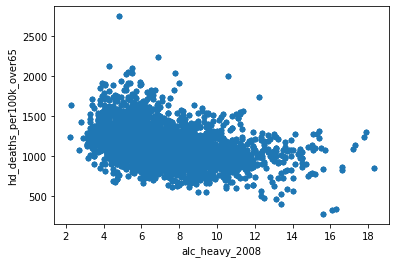

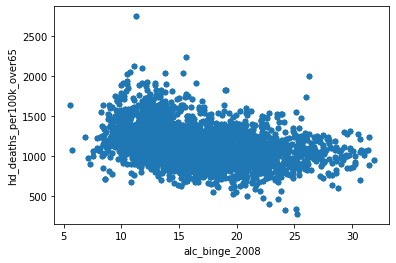

In [11]:
# Plot all features against deaths-per-100k - Ignores first and last columns of df (county_state and deaths-per-100k)
for col in df.columns[1:-1]:
    df.plot.scatter(x=col, y='hd_deaths_per100k_over65')

In [12]:
full_data = pd.read_csv('.\data\data_all_features.csv')
full_data.head()

,county_state,hyp_total_2009,cig_total_2012,cig_daily_2012,obs_total_2006,dbt_total_2012,alc_any_2008,alc_heavy_2008,alc_binge_2008,hd_deaths_per100k_over65
0,"Autauga, AL",38.87,25.10,18.41,67.26,11.44,41.2,6.0,13.1,1292.6
1,"Baldwin, AL",36.79,20.90,16.02,76.59,9.76,55.1,9.1,17.7,1182.2
2,"Barbour, AL",47.63,26.25,18.73,59.95,14.65,37.0,5.6,12.0,1508.6
3,"Bibb, AL",43.28,29.41,22.62,59.95,12.32,34.2,5.2,11.6,1362.3
4,"Blount, AL",40.80,27.17,19.88,62.09,11.14,34.1,4.8,10.8,1327.2


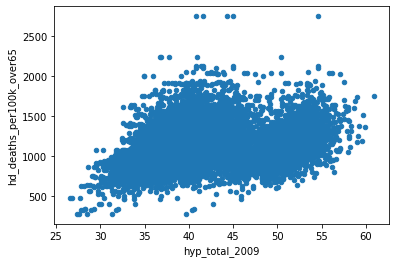

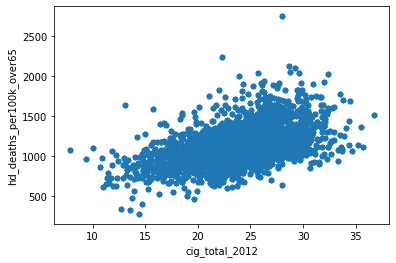

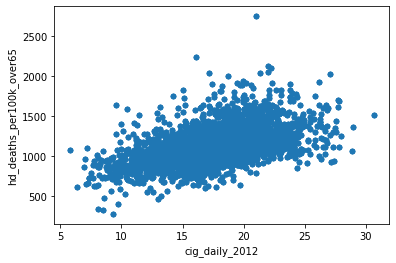

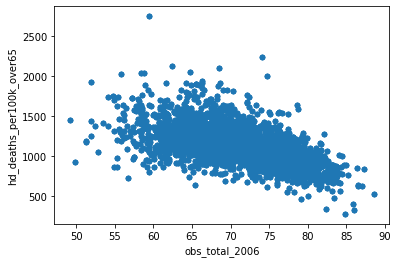

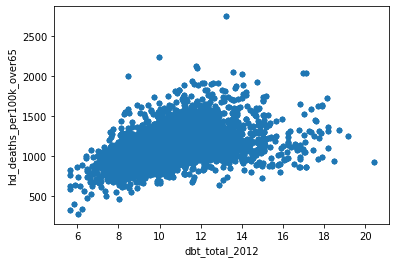

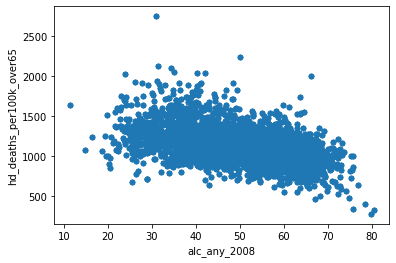

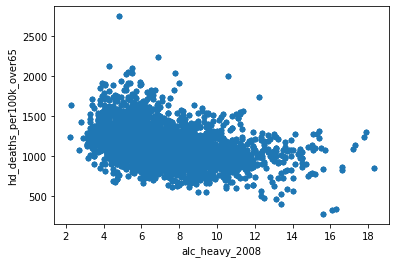

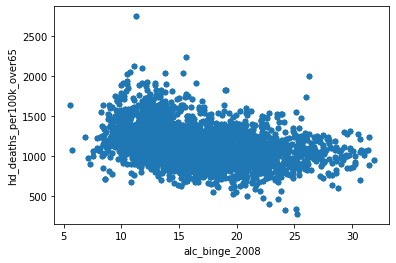

In [13]:
#All features for full data set plotted against hd_deaths_per100k_over65
for col in full_data.columns[1:-1]:
    full_data.plot.scatter(x=col, y='hd_deaths_per100k_over65')

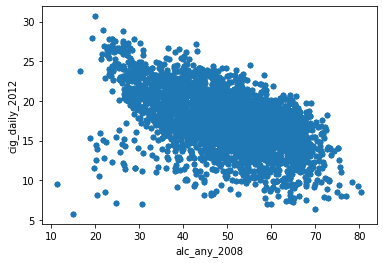

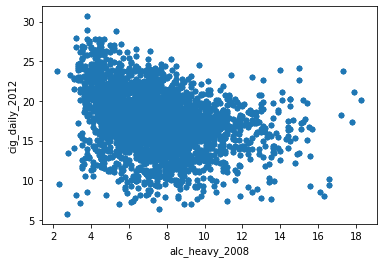

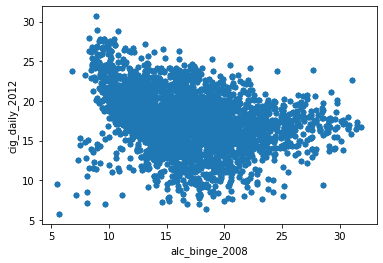

In [14]:
#All alcohol versus cig_total
for col in full_data.columns[6:9]:
    full_data.plot.scatter(x=col ,y='cig_daily_2012')

<AxesSubplot:>

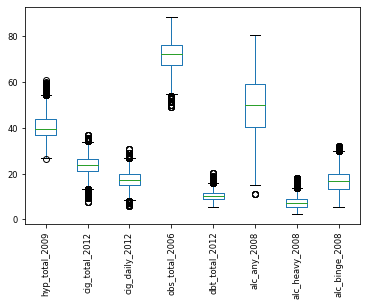

In [15]:
#Boxplots of all features but location
data_features = full_data.drop(['county_state','hd_deaths_per100k_over65'],axis = 1)

data_features.boxplot(grid=False,fontsize='small',rot=90)

<AxesSubplot:>

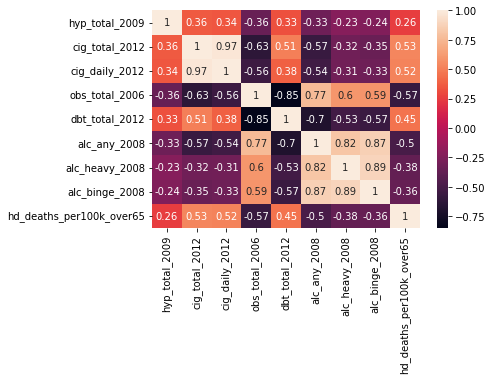

In [16]:
#Heatmap for feature correlation
full_data = full_data.drop(['county_state'],axis=1)
sbn.heatmap(full_data.corr(),annot=True)

<AxesSubplot:>

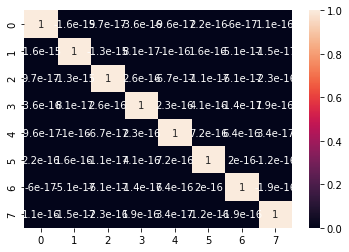

In [17]:
from sklearn.decomposition import PCA
#PCA transformation down to two dimensions and then correlation heatmap
pca = PCA(8)
transformed = pca.fit_transform(data_features)
pca_data = pd.DataFrame(transformed)
sbn.heatmap(pca_data.corr(),annot=True)

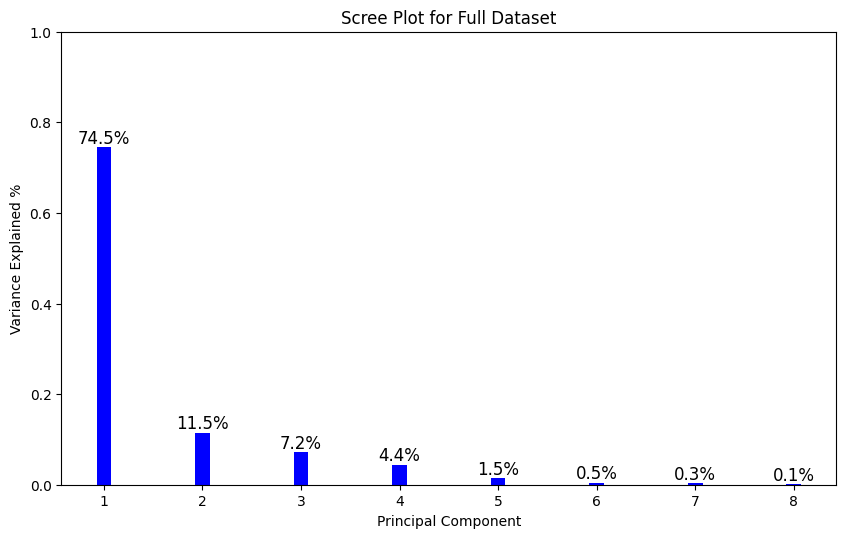

In [18]:
var = pca.explained_variance_ratio_
plt.figure(figsize=(10,6), dpi=100)
plot = plt.subplot(111)
plot.bar(['1','2','3','4','5','6','7','8'],var, width = 0.15, color = ['blue'])
plt.ylim(0,1)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained %")
plt.title("Scree Plot for Full Dataset")
for bar in plot.patches:
    plot.annotate(format(bar.get_height()*100, '.1f') + str('%'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha= "center", va='bottom', size = 12)

In [19]:
#Linear Regression model with full data and 10 fold cross validation
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Training scores: [0.41962741 0.41340372 0.36559202 0.40070243 0.37400973 0.3524761
 0.40084118 0.36733437 0.41553514 0.38768599]
Mean squared error: 34019.58765995934
Coefficient of determination (R2): 0.3651201528764916
[1042.34942153 1357.723647   1146.52326319 ...  939.02265984 1085.57875112
 1010.87716264]


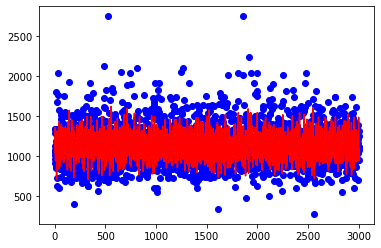

In [20]:
lg = LinearRegression()
scores = cross_val_score(lg, X_train, y_train, cv= 10)
print("Training scores: " + str(scores))
lg = lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))

#Scatter plot of linear regression on all the data features
X_test=np.arange(0,len(X_test),1)
print(y_pred)
plt.scatter(X_test,y_test, color="blue")
plt.plot(X_test,y_pred, color = "red")

In [21]:
#PCR model using the PCA transformed data with 3 components
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Mean squared error: 30453.21220221545
Coefficient of determination (R2): 0.3594836692027561
[1169.03524989 1135.84962314 1049.67017688 ... 1031.48707514  891.55147825
 1012.16065026]


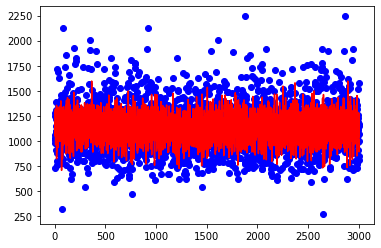

In [22]:
pcr = make_pipeline(StandardScaler(), PCA(n_components = 3), LinearRegression())
pcr.fit(X_train, y_train)

y_pred = pcr.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))
#Scatter plot of PCA linear regression on all the 3 components
X_test=np.arange(0,len(X_test),1)
print(y_pred)
plt.scatter(X_test,y_test, color="blue")
plt.plot(X_test,y_pred, color = "red")

In [23]:
#Linear regression model with one alcohol column, one cig column, and the rest of the data columns
alcohol = ['alc_any_2008', 'alc_heavy_2008', 'alc_binge_2008']
cig = ['cig_total_2012', 'cig_daily_2012']

one_cig_one_alc_dfs = list()
for a in range(0,len(alcohol)):
    for c in range(0,len(cig)):
        a1 = alcohol[a]
        if a+1 == len(alcohol):
            a2 = alcohol[0]
        else: 
            a2 = alcohol[a+1]
        c= cig[c]
        data = data_features.drop(columns = ([a1,a2,c]))
        one_cig_one_alc_dfs.append(data)
        



In [24]:
#Linear Regression model with one alcohol column, one cig column, and 10 fold cross validation
for i in range(0,len(one_cig_one_alc_dfs)):
    X= one_cig_one_alc_dfs[i]
    y = full_data['hd_deaths_per100k_over65']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    print(X.columns.values.tolist())
    
    lg = LinearRegression()
    scores = cross_val_score(lg, X_train, y_train, cv= 10)
    print("Training scores: " + str(scores))
    lg = lg.fit(X_train, y_train)
    y_pred = lg.predict(X_test)
    print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
    print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')

    

['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_binge_2008']
Training scores: [0.38843153 0.36322106 0.38689899 0.33056145 0.37740668 0.36790193
 0.39272915 0.37642903 0.38878635 0.39447203]
Mean squared error: 29790.65186130011
Coefficient of determination (R2): 0.3962269502131186

['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_binge_2008']
Training scores: [0.36466251 0.3951302  0.36493795 0.38906947 0.34350581 0.416204
 0.32591058 0.35791378 0.41809284 0.36818043]
Mean squared error: 32350.539410003952
Coefficient of determination (R2): 0.379985914369377

['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_any_2008']
Training scores: [0.43131643 0.40439989 0.34163783 0.37902214 0.38344904 0.38406781
 0.36898847 0.36712882 0.37330534 0.38446292]
Mean squared error: 32156.19729160231
Coefficient of determination (R2): 0.3843599515754852

['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', 'dbt_to

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


Training scores: [0.0540769  0.05910766 0.05458052 0.05291752 0.08919861 0.06723772
 0.06286161 0.07518037 0.06795836 0.06332766]
Mean squared error: 50031.150846125216
Coefficient of determination (R2): 0.06341936281103133



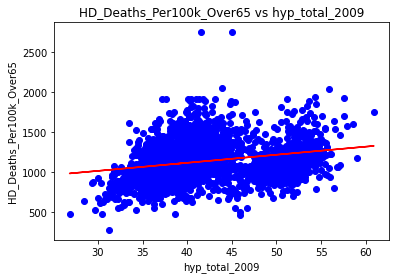

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


Training scores: [0.28117434 0.28251181 0.29935773 0.26320162 0.34031388 0.28650757
 0.27004975 0.28909577 0.27937959 0.30385404]
Mean squared error: 39760.13411586267
Coefficient of determination (R2): 0.2625372579734042



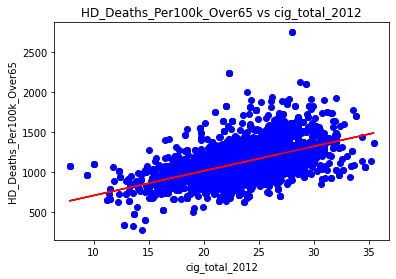

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


Training scores: [0.26633334 0.32606308 0.2943042  0.23561712 0.29849572 0.25719506
 0.2105758  0.23048918 0.28862127 0.25024754]
Mean squared error: 40272.480221067926
Coefficient of determination (R2): 0.26453097080883214



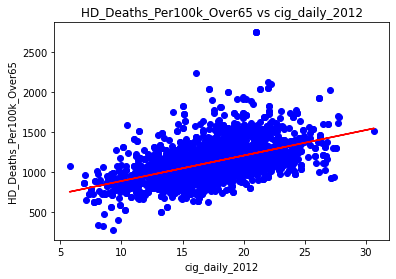

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


Training scores: [0.36771209 0.31309455 0.30440156 0.27257628 0.31290552 0.29989761
 0.33255353 0.32890644 0.35270452 0.36027826]
Mean squared error: 35987.27025501097
Coefficient of determination (R2): 0.30883301826080034



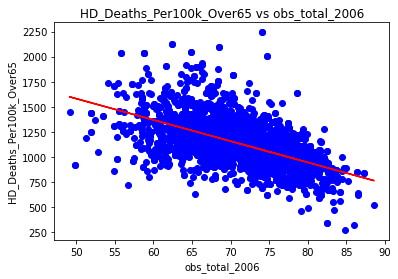

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


Training scores: [0.1538941  0.17840018 0.24228248 0.18198464 0.21775036 0.22839308
 0.21771298 0.21237277 0.21140514 0.22304966]
Mean squared error: 40564.732194654025
Coefficient of determination (R2): 0.19215061219338025



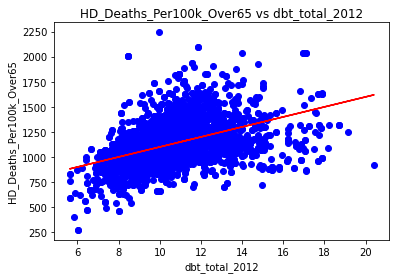

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


Training scores: [0.24185714 0.24800341 0.28718704 0.20991036 0.23988905 0.27390305
 0.21885535 0.23230837 0.26208553 0.26016623]
Mean squared error: 39116.62469816708
Coefficient of determination (R2): 0.25358461592689774



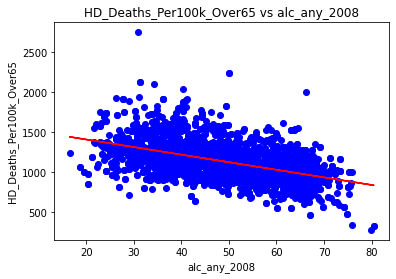

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


Training scores: [0.12361041 0.15144462 0.13815599 0.1745586  0.14220829 0.15594914
 0.15646174 0.10714224 0.17548291 0.1415599 ]
Mean squared error: 44154.70316688421
Coefficient of determination (R2): 0.11712871977172845



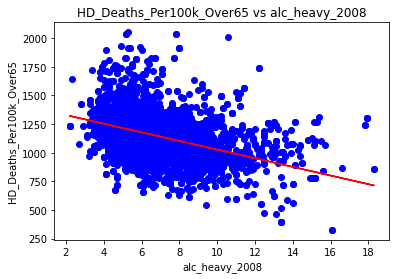

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_14864\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


Training scores: [0.10193867 0.13805641 0.11936637 0.10555702 0.14565584 0.13525742
 0.13507746 0.13165153 0.10859544 0.11218557]
Mean squared error: 47066.04433889644
Coefficient of determination (R2): 0.14239867349799884



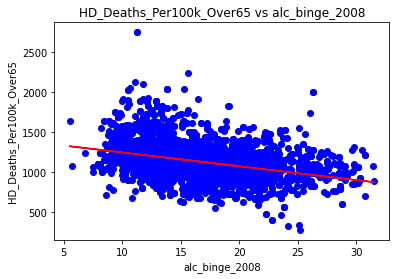

In [25]:
#Linear regression of each feature alone
n,m = data_features.shape
for i in range(0,m):
    
    X = data_features.iloc[:,i]
    y = full_data['hd_deaths_per100k_over65']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    lg = LinearRegression()
    scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
    print("Training scores: " + str(scores))
  
    lg = lg.fit(X_train[:,np.newaxis], y_train)
    y_pred = lg.predict(X_test[:,np.newaxis])
    print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
    print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')
    
    #Scatter plot of PCA linear regression on all the 3 components
    plt.scatter(X_test,y_test, color="blue")
    plt.plot(X_test,y_pred, color = "red")
    plt.ylabel('HD_Deaths_Per100k_Over65')
    plt.xlabel(data_features.columns[i])
    plt.title('HD_Deaths_Per100k_Over65 vs ' + str(data_features.columns[i]))
    plt.show()

In [26]:
#Lasso regression with all features
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [27]:
lasso = Lasso()
scores = cross_val_score(lasso, X_train, y_train, cv= 10)
print("Training scores: " + str(scores))
lasso = lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))


Training scores: [0.40416598 0.42063112 0.38255107 0.35170117 0.40274381 0.35984371
 0.40025876 0.39760148 0.38191582 0.33755859]
Mean squared error: 31220.849400322048
Coefficient of determination (R2): 0.38449811950675716


In [28]:
#Lasso Regression model with one alcohol column, one cig column, and 10 fold cross validation
for i in range(0,len(one_cig_one_alc_dfs)):
    X= one_cig_one_alc_dfs[i]
    y = full_data['hd_deaths_per100k_over65']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    print(X.columns.values.tolist())
    
    lasso = Lasso()
    scores = cross_val_score(lasso, X_train, y_train, cv= 10)
    print("Training scores: " + str(scores))
    lasso = lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
    print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')


['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_binge_2008']
Training scores: [0.39158684 0.36762041 0.38158082 0.39380284 0.36856028 0.39281696
 0.36513338 0.38575925 0.38929592 0.38793726]
Mean squared error: 33435.96536419334
Coefficient of determination (R2): 0.3727987901941364

['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_binge_2008']
Training scores: [0.37371834 0.3777589  0.38836173 0.35239195 0.3766207  0.35997174
 0.37280947 0.42057406 0.41098515 0.37449101]
Mean squared error: 34234.26764852924
Coefficient of determination (R2): 0.3569010818594549

['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_any_2008']
Training scores: [0.35846066 0.40220241 0.35164335 0.38104633 0.38382487 0.42263902
 0.37368968 0.41623417 0.37759772 0.32784579]
Mean squared error: 30308.110951975552
Coefficient of determination (R2): 0.39466729420378033

['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', 'db

In [29]:
#Random Forest Regressor with all features
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [30]:
forest = RandomForestRegressor(n_estimators = 10) 
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)
y_pred_train = forest.predict(X_train)
print('TRAIN DATA: Mean squared error: ' + str(mean_squared_error(y_train,y_pred_train)))
print('TRAIN DATA: Coefficient of determination (R2): ' + str(r2_score(y_train, y_pred_train)) + '\n')
print('TEST DATA: Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('TEST DATA: Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')


TRAIN DATA: Mean squared error: 305.0917045522637
TRAIN DATA: Coefficient of determination (R2): 0.9940464539027284

TEST DATA: Mean squared error: 1218.2844957057252
TEST DATA: Coefficient of determination (R2): 0.9778294234741035



In [55]:
forest = RandomForestRegressor(n_estimators = 100, max_depth = 20,min_samples_split = 10, min_samples_leaf = 10, max_features = 'log2') 
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)
y_pred_train = forest.predict(X_train)
print('TRAIN DATA: Mean squared error: ' + str(mean_squared_error(y_train,y_pred_train)))
print('TRAIN DATA: Coefficient of determination (R2): ' + str(r2_score(y_train, y_pred_train)) + '\n')
print('TEST DATA: Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('TEST DATA: Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')


TRAIN DATA: Mean squared error: 8695.796615722627
TRAIN DATA: Coefficient of determination (R2): 0.8303106074936425

TEST DATA: Mean squared error: 13232.076376227044
TEST DATA: Coefficient of determination (R2): 0.7592001187491844



In [52]:
tree = DecisionTreeRegressor(max_depth = 20, min_samples_split = 10 ,min_samples_leaf = 10, max_features = 'log2')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)
print('TRAIN DATA: Mean squared error: ' + str(mean_squared_error(y_train,y_pred_train)))
print('TRAIN DATA: Coefficient of determination (R2): ' + str(r2_score(y_train, y_pred_train)) + '\n')
print('TEST DATA: Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('TEST DATA: Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')


TRAIN DATA: Mean squared error: 10180.137523723657
TRAIN DATA: Coefficient of determination (R2): 0.8013452443323632

TEST DATA: Mean squared error: 15053.778298680352
TEST DATA: Coefficient of determination (R2): 0.7260484353603813



In [33]:
#Find optimal hyperparameters for random forest
parameters = {'n_estimators' : [10, 100],
'max_depth' : [10, 50],
'min_samples_split' : [2, 10],
'min_samples_leaf' : [5, 10],
'max_features' : ('auto', 'log2')}

forest = RandomForestRegressor()
clf = GridSearchCV(forest, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 50],
                         'max_features': ('auto', 'log2'),
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [2, 10],
                         'n_estimators': [10, 100]})

In [50]:
#Best hyperparams based on r2 score 
clf.best_params_
train_y_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)
print("Train: " + str(r2_score(y_train,train_y_pred)))
print("Test: " + str(r2_score(y_test,y_pred)))

Train: 0.9539203549180897
Test: 0.9077264753635226


In [56]:
#Comparing how the max depth affects the accuracy. Graph shows the trend as the depth increases. 
#All other hyperparams are set to scikit-learn default

max_depth = [5, 10, 15, 20, 25, 50, 100]
test_r2 = list()
train_r2 = list()

for i in range(0, len(max_depth)):
    forest = RandomForestRegressor(max_depth = max_depth[i])
    forest.fit(X_train,y_train)
    y_pred = forest.predict(X_test)
    train_pred = forest.predict(X_train)
    
    test_r2.append(r2_score(y_test, y_pred))
    train_r2.append(r2_score(y_train, train_pred))

In [57]:
train_scores = np.array(train_r2)
test_scores = np.array(test_r2)

In [58]:
depth_scores = pd.DataFrame(train_scores, columns = ['Train Scores'])

In [59]:
depth_scores['Max Depth'] = max_depth
depth_scores['Test Scores'] = test_scores

Text(0.5, 1.0, 'Affect of Tree Depth on Training R2 Score')

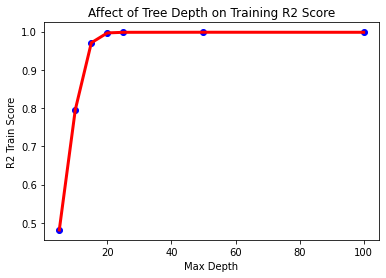

In [61]:
#Plotting the max depth of the tree vs r2 scores
plt.scatter(depth_scores['Max Depth'],depth_scores['Train Scores'], color = "blue")
plt.plot(depth_scores['Max Depth'],depth_scores['Train Scores'], color = "red", linewidth = 3)
plt.xlabel("Max Depth")
plt.ylabel("R2 Train Score")
plt.title("Affect of Tree Depth on Training R2 Score")

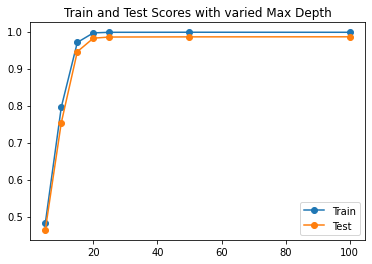

In [63]:
plt.plot(depth_scores['Max Depth'],depth_scores['Train Scores'], "-o", label = "Train")
plt.plot(depth_scores['Max Depth'],depth_scores['Test Scores'], "-o", label = "Test")
plt.legend()
plt.title("Train and Test Scores with varied Max Depth")
plt.show()

In [64]:
#Comparing how the number of estimators affects the accuracy. Graph shows the trend as the number of estimators increases. 
#All other hyperparams are set to scikit-learn default

estimators = [5, 10, 15, 20, 25, 50, 100]
test_r2 = list()
train_r2 = list()

for i in range(0, len(max_depth)):
    forest = RandomForestRegressor(n_estimators = estimators[i])
    forest.fit(X_train,y_train)
    y_pred = forest.predict(X_test)
    train_pred = forest.predict(X_train)
    
    test_r2.append(r2_score(y_test, y_pred))
    train_r2.append(r2_score(y_train, train_pred))

In [65]:
test_scores = np.array(test_r2)
train_scores = np.array(train_r2)
estimators_scores = pd.DataFrame(scores, columns = ['Test Scores'])
estimators_scores['Train Scores'] = train_scores
estimators_scores['Num Estimators'] = estimators

Text(0.5, 1.0, 'Num Estimators affect on R2 Scores')

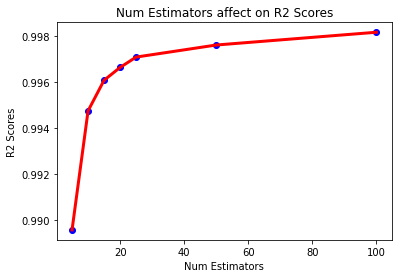

In [67]:
plt.scatter(estimators_scores['Num Estimators'], estimators_scores['Train Scores'], color = "blue")
plt.plot(estimators_scores['Num Estimators'], estimators_scores['Train Scores'], color = "red", linewidth = 3)
plt.xlabel("Num Estimators")
plt.ylabel("R2 Scores")
plt.title("Num Estimators affect on R2 Scores")

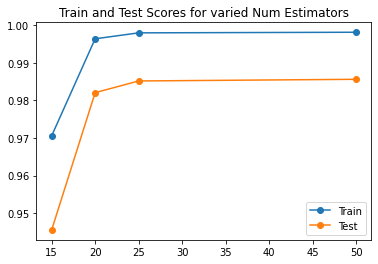

In [78]:
plt.plot(depth_scores.iloc[2:6,1],depth_scores.iloc[2:6,0],"-o", label = "Train")
plt.plot(depth_scores.iloc[2:6,1],depth_scores.iloc[2:6,2], "-o", label = "Test")
plt.legend()
plt.title("Train and Test Scores for varied Num Estimators")
plt.show()